<a href="https://colab.research.google.com/github/Freesoul-tech/Louis-Mahobe/blob/main/DeepNN1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [27]:
class FC:
    def __init__(self, n_nodes1, n_nodes2, initializer, optimizer):
        self.W = initializer.W(n_nodes1, n_nodes2)
        self.B = initializer.B(n_nodes2)
        self.optimizer = optimizer

    def forward(self, X):
        self.X = X
        A = np.dot(X, self.W) + self.B
        return A

    def backward(self, dA):
        dW = np.dot(self.X.T, dA)
        dB = np.sum(dA, axis=0)
        dZ = np.dot(dA, self.W.T)

        self.dW = dW
        self.dB = dB
        self = self.optimizer.update(self)
        return dZ


In [28]:
class SimpleInitializer:
    def __init__(self, sigma):
        self.sigma = sigma

    def W(self, n_nodes1, n_nodes2):
        return np.random.randn(n_nodes1, n_nodes2) * self.sigma

    def B(self, n_nodes2):
        return np.zeros(n_nodes2)


In [29]:
class XavierInitializer:
    def W(self, n_nodes1, n_nodes2):
        sigma = np.sqrt(1.0 / n_nodes1)
        return np.random.randn(n_nodes1, n_nodes2) * sigma

    def B(self, n_nodes2):
        return np.zeros(n_nodes2)


In [30]:
class HeInitializer:
    def W(self, n_nodes1, n_nodes2):
        sigma = np.sqrt(2.0 / n_nodes1)
        return np.random.randn(n_nodes1, n_nodes2) * sigma

    def B(self, n_nodes2):
        return np.zeros(n_nodes2)


In [31]:
class SGD:
    def __init__(self, lr):
        self.lr = lr

    def update(self, layer):
        layer.W -= self.lr * layer.dW
        layer.B -= self.lr * layer.dB
        return layer


In [32]:
class AdaGrad:
    def __init__(self, lr):
        self.lr = lr
        self.h_W = {}
        self.h_B = {}
        self.epsilon = 1e-7

    def update(self, layer):
        if layer not in self.h_W:
            self.h_W[layer] = np.zeros_like(layer.W)
            self.h_B[layer] = np.zeros_like(layer.B)

        self.h_W[layer] += layer.dW ** 2
        self.h_B[layer] += layer.dB ** 2

        layer.W -= self.lr * layer.dW / (np.sqrt(self.h_W[layer]) + self.epsilon)
        layer.B -= self.lr * layer.dB / (np.sqrt(self.h_B[layer]) + self.epsilon)
        return layer


In [33]:
class ReLU:
    def forward(self, X):
        self.X = X
        return np.maximum(0, X)

    def backward(self, dA):
        dZ = dA.copy()
        dZ[self.X <= 0] = 0
        return dZ



In [34]:
class Softmax:
    def forward(self, X):
        self.out = np.exp(X - np.max(X, axis=1, keepdims=True))
        self.out /= np.sum(self.out, axis=1, keepdims=True)
        return self.out

    def backward(self, Y):
        batch_size = Y.shape[0]
        return (self.out - Y) / batch_size


In [35]:
class ScratchDeepNeuralNetrowkClassifier:
    def __init__(self, n_features, n_nodes1, n_nodes2, n_output, lr, initializer, optimizer):
        self.n_features = n_features
        self.n_nodes1 = n_nodes1
        self.n_nodes2 = n_nodes2
        self.n_output = n_output
        self.lr = lr

        self.optimizer_instance = optimizer(self.lr)

        self.FC1 = FC(n_features, n_nodes1, initializer, self.optimizer_instance)
        self.activation1 = ReLU() # Create a separate instance for the first layer
        self.FC2 = FC(n_nodes1, n_nodes2, initializer, self.optimizer_instance)
        self.activation2 = ReLU() # Create a separate instance for the second layer
        self.FC3 = FC(n_nodes2, n_output, initializer, self.optimizer_instance)
        self.activation3 = Softmax()

    def fit(self, X, Y, epochs, X_val=None, Y_val=None):
        self.train_loss = []
        self.val_accuracy = []

        for _ in range(epochs):
            # Forward
            A1 = self.FC1.forward(X)
            Z1 = self.activation1.forward(A1)
            A2 = self.FC2.forward(Z1)
            Z2 = self.activation2.forward(A2)
            A3 = self.FC3.forward(Z2)
            Z3 = self.activation3.forward(A3)

            # Loss
            loss = -np.sum(Y * np.log(Z3 + 1e-7)) / len(Y)
            self.train_loss.append(loss)

            # Backward
            dA3 = self.activation3.backward(Y)
            dZ2 = self.FC3.backward(dA3)
            dA2 = self.activation2.backward(dZ2)
            dZ1 = self.FC2.backward(dA2)
            dA1 = self.activation1.backward(dZ1)
            _ = self.FC1.backward(dA1)

            # Validation accuracy
            if X_val is not None and Y_val is not None:
                preds = self.predict(X_val)
                acc = np.mean(np.argmax(Y_val, axis=1) == preds)
                self.val_accuracy.append(acc)


    def predict(self, X):
        A1 = self.FC1.forward(X)
        Z1 = self.activation1.forward(A1)
        A2 = self.FC2.forward(Z1)
        Z2 = self.activation2.forward(A2)
        A3 = self.FC3.forward(Z2)
        Z3 = self.activation3.forward(A3)
        return np.argmax(Z3, axis=1)

In [36]:
from sklearn.datasets import fetch_openml
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
import numpy as np

# Load MNIST
mnist = fetch_openml('mnist_784')
X = mnist.data / 255.0
Y = OneHotEncoder(sparse_output=False).fit_transform(mnist.target.values.reshape(-1, 1))

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2)

# Train
model = ScratchDeepNeuralNetrowkClassifier(
    n_features=784,
    n_nodes1=128,
    n_nodes2=64,
    n_output=10,
    lr=0.01,
    initializer=HeInitializer(),
    optimizer=AdaGrad
)
model.fit(X_train, Y_train, epochs=10)

# Evaluate
preds = model.predict(X_test)
accuracy = np.mean(np.argmax(Y_test, axis=1) == preds)
print(f"Accuracy: {accuracy:.4f}")

Accuracy: 0.7729


In [37]:
def fit(self, X, Y, epochs, X_val=None, Y_val=None):
    self.train_loss = []
    self.val_accuracy = []

    for _ in range(epochs):
        # Forward
        A1 = self.FC1.forward(X)
        Z1 = self.activation1.forward(A1)
        A2 = self.FC2.forward(Z1)
        Z2 = self.activation2.forward(A2)
        A3 = self.FC3.forward(Z2)
        Z3 = self.activation3.forward(A3)

        # Loss
        loss = -np.sum(Y * np.log(Z3 + 1e-7)) / len(Y)
        self.train_loss.append(loss)

        # Backward
        dA3 = self.activation3.backward(Y)
        dZ2 = self.FC3.backward(dA3)
        dA2 = self.activation2.backward(dZ2)
        dZ1 = self.FC2.backward(dA2)
        dA1 = self.activation1.backward(dZ1)
        _ = self.FC1.backward(dA1)

        # Validation accuracy
        if X_val is not None and Y_val is not None:
            preds = self.predict(X_val)
            acc = np.mean(np.argmax(Y_val, axis=1) == preds)
            self.val_accuracy.append(acc)


In [38]:
class Sigmoid:
    def forward(self, X):
        self.out = 1 / (1 + np.exp(-X))
        return self.out

    def backward(self, dA):
        return dA * (1.0 - self.out) * self.out

In [39]:
configs = [
    {"name": "SGD + ReLU", "optimizer": SGD, "initializer": HeInitializer(), "activation": ReLU},
    {"name": "AdaGrad + ReLU", "optimizer": AdaGrad, "initializer": HeInitializer(), "activation": ReLU},
    {"name": "SGD + Sigmoid", "optimizer": SGD, "initializer": XavierInitializer(), "activation": Sigmoid},
]

results = []

for config in configs:
    # Create a new optimizer instance for each configuration
    optimizer_instance = config["optimizer"](0.01) # Use the learning rate defined in the original code

    model = ScratchDeepNeuralNetrowkClassifier(
        n_features=784,
        n_nodes1=128,
        n_nodes2=64,
        n_output=10,
        lr=0.01,
        initializer=config["initializer"],
        optimizer=config["optimizer"] # Pass the optimizer class to the model
    )
    # Activation functions are now set during model initialization
    model.fit(X_train, Y_train, epochs=10, X_val=X_test, Y_val=Y_test)
    results.append((config["name"], model.train_loss, model.val_accuracy))

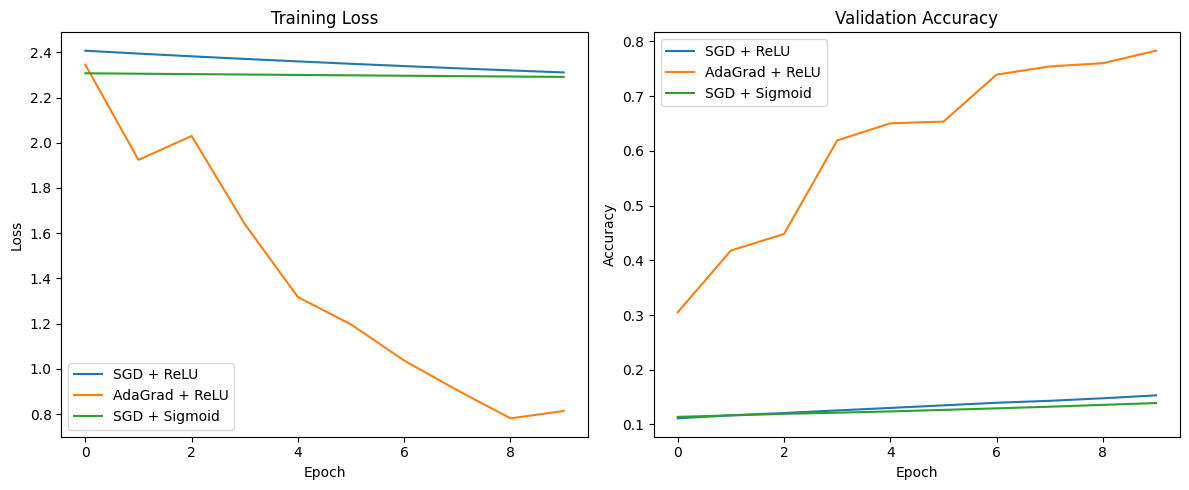

In [40]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 5))

# Loss
plt.subplot(1, 2, 1)
for name, loss, _ in results:
    plt.plot(loss, label=name)
plt.title("Training Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()

# Accuracy
plt.subplot(1, 2, 2)
for name, _, acc in results:
    plt.plot(acc, label=name)
plt.title("Validation Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()

plt.tight_layout()
plt.show()


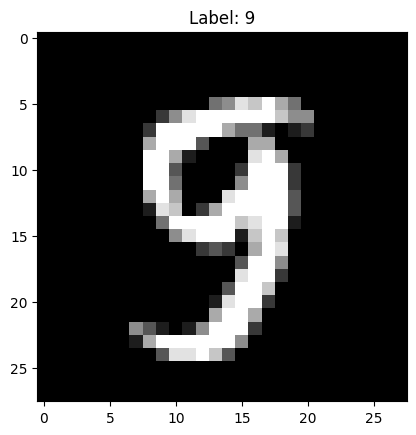

In [41]:
import matplotlib.pyplot as plt
plt.imshow(X_train.iloc[0].values.reshape(28, 28), cmap='gray')
plt.title(f"Label: {np.argmax(Y_train[0])}")
plt.show()



In [42]:
type(X_train)


pandas.core.frame.DataFrame

In [43]:
class ScratchDeepNeuralNetrowkClassifier:
    def __init__(self, n_features, n_nodes1, n_nodes2, n_output, lr, initializer, optimizer):
        self.n_features = n_features
        self.n_nodes1 = n_nodes1
        self.n_nodes2 = n_nodes2
        self.n_output = n_output
        self.lr = lr

        self.optimizer_instance = optimizer(self.lr)

        self.FC1 = FC(n_features, n_nodes1, initializer, self.optimizer_instance)
        self.activation1 = ReLU()
        self.FC2 = FC(n_nodes1, n_nodes2, initializer, self.optimizer_instance)
        self.activation2 = ReLU()
        self.FC3 = FC(n_nodes2, n_output, initializer, self.optimizer_instance)
        self.activation3 = Softmax()

    def fit(self, X, Y, epochs, X_val=None, Y_val=None):
        self.train_loss = []
        self.val_accuracy = []

        for _ in range(epochs):
            # Forward
            A1 = self.FC1.forward(X)
            Z1 = self.activation1.forward(A1)
            A2 = self.FC2.forward(Z1)
            Z2 = self.activation2.forward(A2)
            A3 = self.FC3.forward(Z2)
            Z3 = self.activation3.forward(A3)

            # Loss
            loss = -np.sum(Y * np.log(Z3 + 1e-7)) / len(Y)
            self.train_loss.append(loss)

            # Backward
            dA3 = self.activation3.backward(Y)
            dZ2 = self.FC3.backward(dA3)
            dA2 = self.activation2.backward(dZ2)
            dZ1 = self.FC2.backward(dA2)
            dA1 = self.activation1.backward(dZ1)
            _ = self.FC1.backward(dA1)

            # Validation accuracy
            if X_val is not None and Y_val is not None:
                preds = self.predict(X_val)
                acc = np.mean(np.argmax(Y_val, axis=1) == preds)
                self.val_accuracy.append(acc)


    def predict(self, X):
        A1 = self.FC1.forward(X)
        Z1 = self.activation1.forward(A1)
        A2 = self.FC2.forward(Z1)
        Z2 = self.activation2.forward(A2)
        A3 = self.FC3.forward(Z2)
        Z3 = self.activation3.forward(A3)
        return np.argmax(Z3, axis=1)

In [44]:
class SGD:
    def __init__(self, lr):
        self.lr = lr

    def update(self, layer):
        layer.W -= self.lr * layer.dW
        layer.B -= self.lr * layer.dB
        return layer


In [45]:
class HeInitializer:
    def W(self, n_nodes1, n_nodes2):
        sigma = np.sqrt(2.0 / n_nodes1)
        return np.random.randn(n_nodes1, n_nodes2) * sigma

    def B(self, n_nodes2):
        return np.zeros(n_nodes2)


In [46]:
from sklearn.datasets import fetch_openml
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
import numpy as np
import matplotlib.pyplot as plt

# Load and preprocess MNIST
mnist = fetch_openml('mnist_784')
X = mnist.data / 255.0
Y = OneHotEncoder(sparse_output=False).fit_transform(mnist.target.values.reshape(-1, 1))
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2)


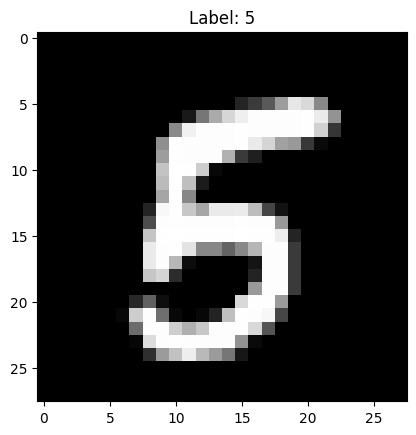

In [47]:
plt.imshow(X_train.iloc[0].values.reshape(28, 28), cmap='gray')
plt.title(f"Label: {np.argmax(Y_train[0])}")
plt.show()


In [48]:
class FC:
    def __init__(self, n_nodes1, n_nodes2, initializer, optimizer):
        self.W = initializer.W(n_nodes1, n_nodes2)
        self.B = initializer.B(n_nodes2)
        self.optimizer = optimizer

    def forward(self, X):
        self.X = X
        A = np.dot(X, self.W) + self.B
        return A

    def backward(self, dA):
        dW = np.dot(self.X.T, dA)
        dB = np.sum(dA, axis=0)
        dZ = np.dot(dA, self.W.T)
        self.dW = dW
        self.dB = dB
        self = self.optimizer.update(self)
        return dZ


In [49]:
class ReLU:
    def forward(self, X):
        self.X = X
        return np.maximum(0, X)

    def backward(self, dA):
        dZ = dA.copy()
        dZ[self.X <= 0] = 0
        return dZ


In [50]:
model = ScratchDeepNeuralNetrowkClassifier(
    n_features=784,
    n_nodes1=128,
    n_nodes2=64,
    n_output=10,
    lr=0.01,
    initializer=HeInitializer(),
    optimizer=SGD
)
model.fit(X_train, Y_train, epochs=10, X_val=X_test, Y_val=Y_test)


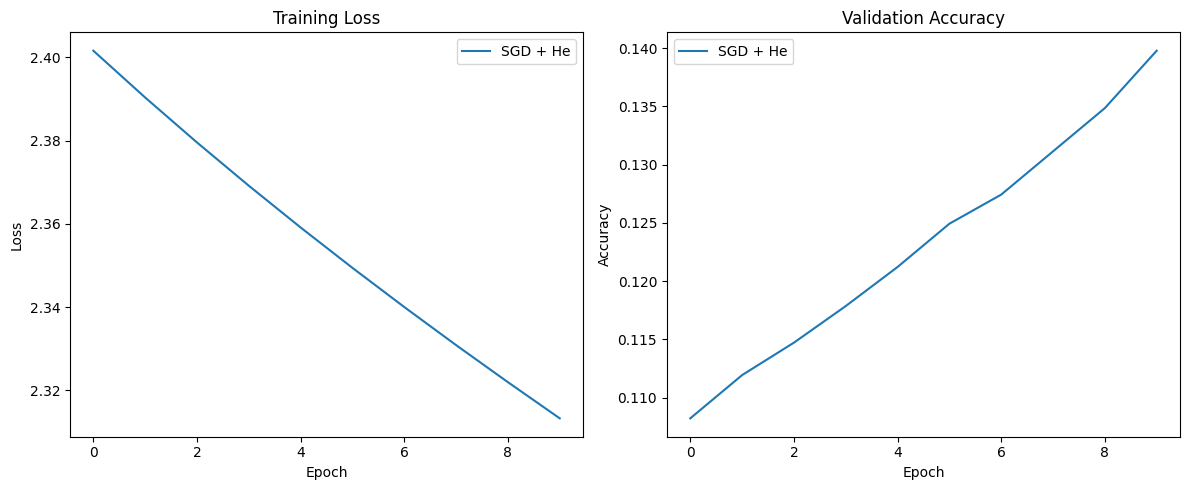

In [51]:
plt.figure(figsize=(12, 5))

# Loss
plt.subplot(1, 2, 1)
plt.plot(model.train_loss, label='SGD + He')
plt.title("Training Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()

# Accuracy
plt.subplot(1, 2, 2)
plt.plot(model.val_accuracy, label='SGD + He')
plt.title("Validation Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()

plt.tight_layout()
plt.show()
